## Import Important Packages

In [1]:
# import ipackages
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

# import functions from library folder
from library.prepare_data import prepare_simulation_data
from library.continuum_grid import compute_continuum_grid
from library.yt_fields import add_flux_fields
from library.visualization import (
    create_projection_plot, 
    create_phase_plot, 
    create_spectrum_plot
)

## Useful Inputs

In [2]:
# define useful inputs
input_path = "output_00273/info_00273.txt"
z = 10 # redshift
filter_file = "F200W_filter.txt"

# calculate distance of object for defined redshift
cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.3)
distance_Mpc = cosmo.angular_diameter_distance_z1z2(0, z)
distance_pc = distance_Mpc.to("pc").value

## Example: Single Filter Case (JWST Filter)

In [3]:
# prepare simulation data
ds, ad, ctr, pop2, wl_shifted, trans, width = prepare_simulation_data(
    input_path = input_path,
    filter_path = filter_file,
    z = z
)

yt : [INFO     ] 2026-02-09 20:09:31,654 Parameters: current_time              = 4.311420483661945
yt : [INFO     ] 2026-02-09 20:09:31,654 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2026-02-09 20:09:31,654 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2026-02-09 20:09:31,655 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2026-02-09 20:09:31,655 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2026-02-09 20:09:31,655 Parameters: current_redshift          = 12.171087046255657
yt : [INFO     ] 2026-02-09 20:09:31,655 Parameters: omega_lambda              = 0.685000002384186
yt : [INFO     ] 2026-02-09 20:09:31,656 Parameters: omega_matter              = 0.314999997615814
yt : [INFO     ] 2026-02-09 20:09:31,656 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2026-02-09 20:09:31,656 Parameters: hubble_constant           = 0.674000015258789
yt : [WARNING  ] 2026-02-09 20:09:35,097 This output has no 

Loading filter data from file: F200W_filter.txt
Filter wavelength range: 1532.2-2093.1 Å


In [4]:
# compute continuum grid
df_results, interp_funcs = compute_continuum_grid(
    min_temp = 1e3, max_temp = 1e5, num_temp_grid = 15,
    min_dense = 1e-4, max_dense = 1e6, num_dense_grid = 15,
    min_wl = 912, max_wl = 1e5, num_wl_grid = 10000,
    filter_wl = wl_shifted,     # 1D array from prepare_simulation_data
    filter_output = trans,      # 1D array from prepare_simulation_data
    save_dir = "continuum_single"
)

Processing single filter...
Saving dataframe to: continuum_single
Filter range: 1534.0-2091.3 Å
Points with transmission > 0: 614


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


Saved: df_wl1534-2091A.txt (225 rows)
Creating variable df01 for single filter:
  Created df01 = shape (225, 5)


In [5]:
# add fliux fields to yt package
ds, filter_list = add_flux_fields(
    ds = ds, 
    interp_funcs = interp_funcs, 
    min_temp = 1e3, 
    max_temp = 1e5, 
    min_dense = 1e-4, 
    max_dense = 1e6,
    he_h_ratio = 0.1
)

Processing single filter...
Added: flux_contH
Added: flux_cont2p
Added: flux_contff
Added: flux_total

Successfully added fields for single filter


yt : [INFO     ] 2026-02-09 20:10:05,990 Projection completed
yt : [INFO     ] 2026-02-09 20:10:05,992 xlim = 0.491120 0.491223
yt : [INFO     ] 2026-02-09 20:10:05,992 ylim = 0.492725 0.492828
yt : [INFO     ] 2026-02-09 20:10:05,993 xlim = 0.491120 0.491223
yt : [INFO     ] 2026-02-09 20:10:05,993 ylim = 0.492725 0.492828
yt : [INFO     ] 2026-02-09 20:10:05,994 Making a fixed resolution buffer of (('gas', 'flux_total')) 800 by 800


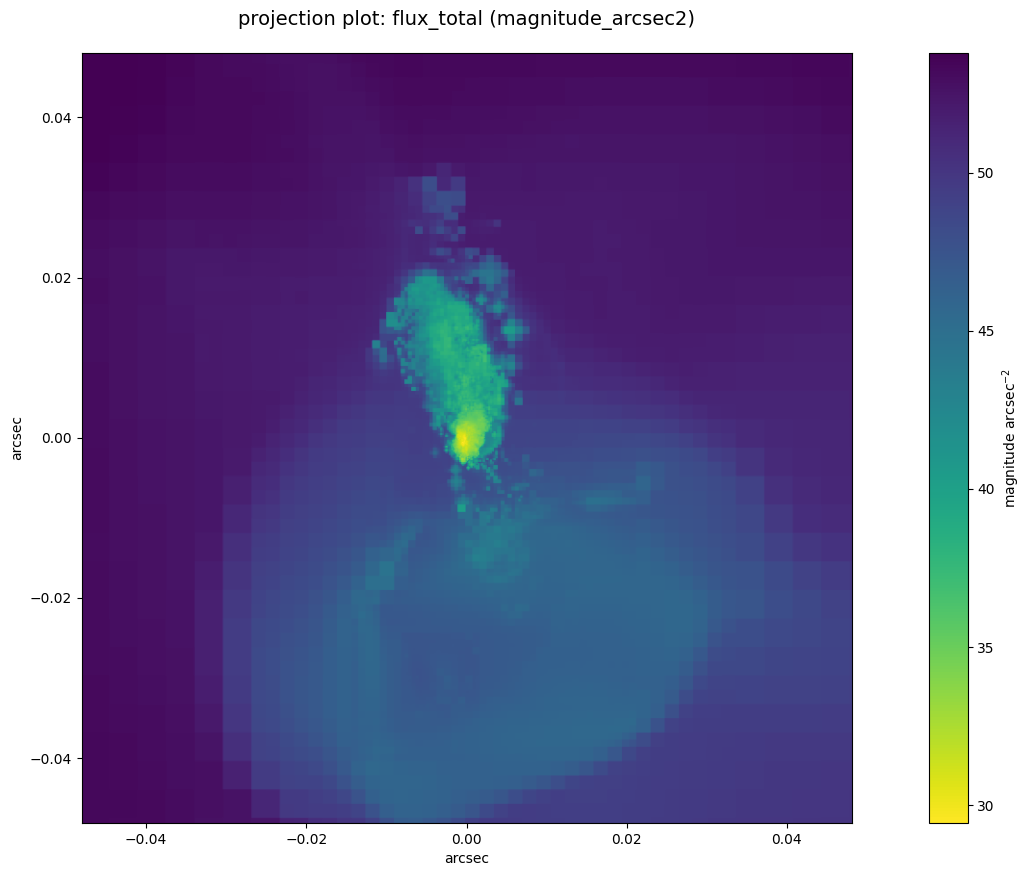

In [6]:
# visualize projection plot
create_projection_plot(
    ds = ds, 
    field_name = "flux_total", # options: "flux_contH", "flux_2p", "flux_ff", "flux_total" 
    ctr_at_code = ctr,        
    z = z,                    
    distance_pc = distance_pc,    
    plt_wdth = width,         
    plot_units = "magnitude_arcsec2", # options: "flux", "jy_arcsec2", "magnitude_arcsec2"
    axis_units = "arcsec", # options: "arcsec", "pc"
    filter_path = filter_file
)


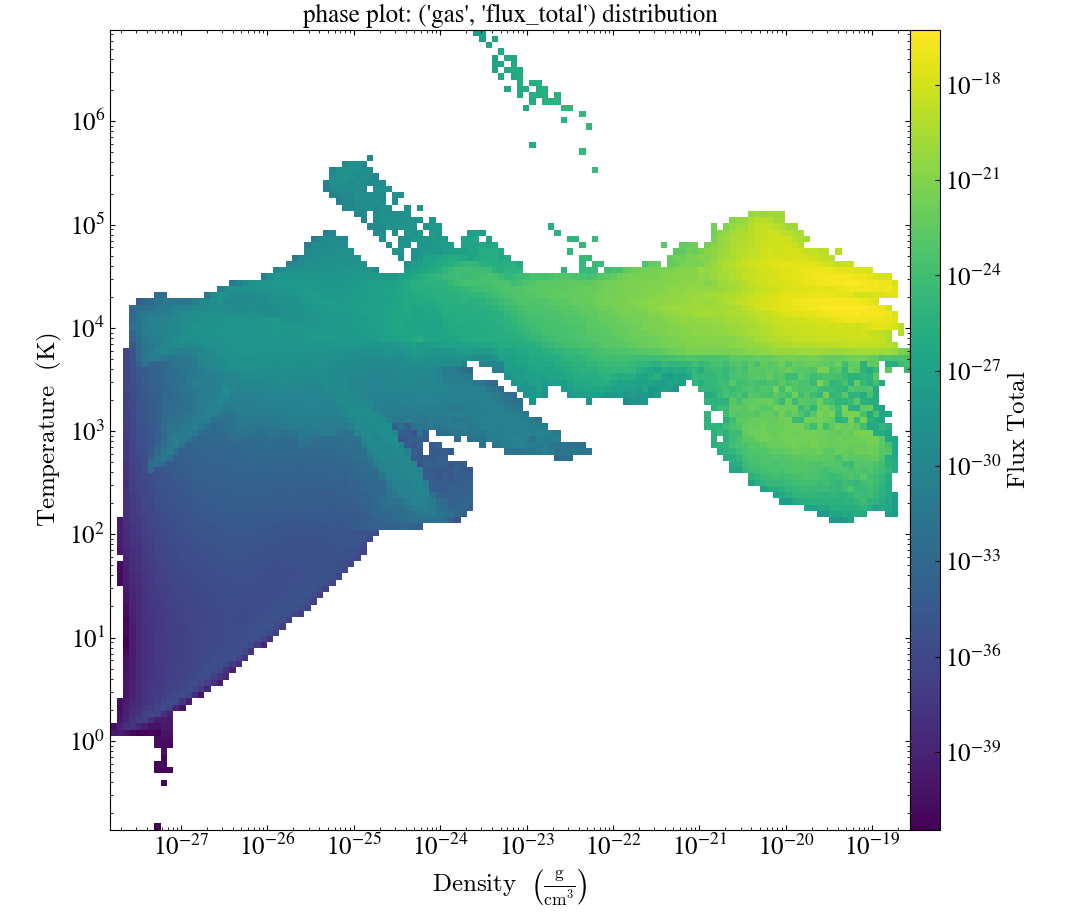

In [7]:
# visualize phase plot
create_phase_plot(
    ad = ad, 
    x_field = ("gas", "density"), 
    y_field = ("gas", "temperature"), 
    z_field = ("gas", "flux_total"),
    # x_bins = (1e-31, 1e-23),         
    # y_bins = (1e3, 1e7),             
    weight_field = None
)

**Note:** Spectra plot can be visualized for multiple filters only.

## Example: Multiple Filters Case

In [8]:
# prepare simulation data
all_ds, all_ad, all_ctr, all_pop2, all_wl_shifted, all_trans, all_width = prepare_simulation_data(
    input_path = input_path,
    filter_path = None,
    z = z,
    filter_dir = "filter_bins",
    wl_initial = 2.0, # this value should be more than 912/1e4 * (1 + z)
    wl_final = 4.0, # this value should be less than 1e5/1e4 * (1 + z) = 10 * (1 + z)
    num_bins = 20
)

yt : [INFO     ] 2026-02-09 20:10:13,743 Parameters: current_time              = 4.311420483661945
yt : [INFO     ] 2026-02-09 20:10:13,744 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2026-02-09 20:10:13,744 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2026-02-09 20:10:13,744 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2026-02-09 20:10:13,745 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2026-02-09 20:10:13,745 Parameters: current_redshift          = 12.171087046255657
yt : [INFO     ] 2026-02-09 20:10:13,745 Parameters: omega_lambda              = 0.685000002384186
yt : [INFO     ] 2026-02-09 20:10:13,745 Parameters: omega_matter              = 0.314999997615814
yt : [INFO     ] 2026-02-09 20:10:13,745 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2026-02-09 20:10:13,746 Parameters: hubble_constant           = 0.674000015258789
yt : [WARNING  ] 2026-02-09 20:10:17,507 This output has no 

No filter file provided... Creating filters automatically in filter_bins
Successfully created 20 filters in filter_bins
Loaded filter 1: filter_1.txt
  Shifted range (z = 10): 1818.2-3635.8 Å
Loaded filter 2: filter_2.txt
  Shifted range (z = 10): 1818.2-3635.8 Å
Loaded filter 3: filter_3.txt
  Shifted range (z = 10): 1818.2-3635.8 Å
Loaded filter 4: filter_4.txt
  Shifted range (z = 10): 1818.2-3635.8 Å
Loaded filter 5: filter_5.txt
  Shifted range (z = 10): 1818.2-3635.8 Å
Loaded filter 6: filter_6.txt
  Shifted range (z = 10): 1818.2-3635.8 Å
Loaded filter 7: filter_7.txt
  Shifted range (z = 10): 1818.2-3635.8 Å
Loaded filter 8: filter_8.txt
  Shifted range (z = 10): 1818.2-3635.8 Å
Loaded filter 9: filter_9.txt
  Shifted range (z = 10): 1818.2-3635.8 Å
Loaded filter 10: filter_10.txt
  Shifted range (z = 10): 1818.2-3635.8 Å
Loaded filter 11: filter_11.txt
  Shifted range (z = 10): 1818.2-3635.8 Å
Loaded filter 12: filter_12.txt
  Shifted range (z = 10): 1818.2-3635.8 Å
Loaded fil

In [9]:
# compute continuum grid
all_dfs, all_interp_funcs = compute_continuum_grid(
    min_temp = 1e3, max_temp = 1e5, num_temp_grid = 15,
    min_dense = 1e-4, max_dense = 1e6, num_dense_grid = 15,
    min_wl = 912, max_wl = 1e5, num_wl_grid = 10000,
    filter_wl = all_wl_shifted,     # 2D array (n_filters, wavelength_points)
    filter_output = all_trans,      # 2D array (n_filters, transmission_points)
    save_dir = "continuum_multi"
)

Processing 20 filters...
Saving dataframes to: continuum_multi

Filter 1/20:
  Filter range: 1818.2-1882.3 Å
  Points with transmission > 0: 70


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_01_wl1818-1882A.txt (225 rows)

Filter 2/20:
  Filter range: 1883.2-1948.3 Å
  Points with transmission > 0: 71


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_02_wl1883-1948A.txt (225 rows)

Filter 3/20:
  Filter range: 1949.2-2017.0 Å
  Points with transmission > 0: 74


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_03_wl1949-2017A.txt (225 rows)

Filter 4/20:
  Filter range: 2018.0-2087.7 Å
  Points with transmission > 0: 76


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_04_wl2018-2088A.txt (225 rows)

Filter 5/20:
  Filter range: 2088.6-2162.0 Å
  Points with transmission > 0: 80


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_05_wl2089-2162A.txt (225 rows)

Filter 6/20:
  Filter range: 2162.9-2238.2 Å
  Points with transmission > 0: 82


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_06_wl2163-2238A.txt (225 rows)

Filter 7/20:
  Filter range: 2239.1-2317.2 Å
  Points with transmission > 0: 85


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_07_wl2239-2317A.txt (225 rows)

Filter 8/20:
  Filter range: 2318.1-2399.0 Å
  Points with transmission > 0: 88


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_08_wl2318-2399A.txt (225 rows)

Filter 9/20:
  Filter range: 2399.9-2483.5 Å
  Points with transmission > 0: 91


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_09_wl2400-2484A.txt (225 rows)

Filter 10/20:
  Filter range: 2484.5-2570.9 Å
  Points with transmission > 0: 94


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_10_wl2484-2571A.txt (225 rows)

Filter 11/20:
  Filter range: 2571.8-2661.9 Å
  Points with transmission > 0: 98


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_11_wl2572-2662A.txt (225 rows)

Filter 12/20:
  Filter range: 2662.9-2755.8 Å
  Points with transmission > 0: 101


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_12_wl2663-2756A.txt (225 rows)

Filter 13/20:
  Filter range: 2756.7-2852.4 Å
  Points with transmission > 0: 104


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_13_wl2757-2852A.txt (225 rows)

Filter 14/20:
  Filter range: 2853.4-2952.8 Å
  Points with transmission > 0: 108


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_14_wl2853-2953A.txt (225 rows)

Filter 15/20:
  Filter range: 2953.7-3057.8 Å
  Points with transmission > 0: 113


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_15_wl2954-3058A.txt (225 rows)

Filter 16/20:
  Filter range: 3058.7-3165.6 Å
  Points with transmission > 0: 116


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_16_wl3059-3166A.txt (225 rows)

Filter 17/20:
  Filter range: 3166.5-3277.1 Å
  Points with transmission > 0: 120


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_17_wl3167-3277A.txt (225 rows)

Filter 18/20:
  Filter range: 3278.0-3392.3 Å
  Points with transmission > 0: 124


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_18_wl3278-3392A.txt (225 rows)

Filter 19/20:
  Filter range: 3393.3-3512.2 Å
  Points with transmission > 0: 129


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_19_wl3393-3512A.txt (225 rows)

Filter 20/20:
  Filter range: 3513.1-3635.8 Å
  Points with transmission > 0: 133


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


  Saved: df_20_wl3513-3636A.txt (225 rows)

Created 20 dataframes and 20 interpolation functions
All dataframes saved to: continuum_multi

Creating variables df01, df02, etc. for available filters:
  Created df01 = shape (225, 5)
  Created df02 = shape (225, 5)
  Created df03 = shape (225, 5)
  Created df04 = shape (225, 5)
  Created df05 = shape (225, 5)
  Created df06 = shape (225, 5)
  Created df07 = shape (225, 5)
  Created df08 = shape (225, 5)
  Created df09 = shape (225, 5)
  Created df10 = shape (225, 5)
  Created df11 = shape (225, 5)
  Created df12 = shape (225, 5)
  Created df13 = shape (225, 5)
  Created df14 = shape (225, 5)
  Created df15 = shape (225, 5)
  Created df16 = shape (225, 5)
  Created df17 = shape (225, 5)
  Created df18 = shape (225, 5)
  Created df19 = shape (225, 5)
  Created df20 = shape (225, 5)


In [14]:
# check if your multiple filters are added correctly
print(all_dfs['filter_10'].head())

   Temperature   Density  Average Specific Flux ContH  \
0       1000.0  0.000100                 1.112409e-33   
1       1000.0  0.000518                 1.112409e-33   
2       1000.0  0.002683                 1.112409e-33   
3       1000.0  0.013895                 1.112409e-33   
4       1000.0  0.071969                 1.112409e-33   

   Average Specific Flux Cont2p  Average Specific Flux Contff  
0                  1.735097e-27                  2.300481e-52  
1                  1.735097e-27                  2.300481e-52  
2                  1.735096e-27                  2.300481e-52  
3                  1.735095e-27                  2.300481e-52  
4                  1.735085e-27                  2.300481e-52  


In [12]:
# add flux fields
all_ds, all_filter_list = add_flux_fields(
    ds = all_ds, 
    interp_funcs = all_interp_funcs, 
    min_temp = 1e3, 
    max_temp = 1e5, 
    min_dense = 1e-4, 
    max_dense = 1e6
)

Processing 20 filters...

Adding fields for filter 01...
  Added: flux_contH_filter_01
  Added: flux_cont2p_filter_01
  Added: flux_contff_filter_01
  Added: flux_total_filter_01

Adding fields for filter 02...
  Added: flux_contH_filter_02
  Added: flux_cont2p_filter_02
  Added: flux_contff_filter_02
  Added: flux_total_filter_02

Adding fields for filter 03...
  Added: flux_contH_filter_03
  Added: flux_cont2p_filter_03
  Added: flux_contff_filter_03
  Added: flux_total_filter_03

Adding fields for filter 04...
  Added: flux_contH_filter_04
  Added: flux_cont2p_filter_04
  Added: flux_contff_filter_04
  Added: flux_total_filter_04

Adding fields for filter 05...
  Added: flux_contH_filter_05
  Added: flux_cont2p_filter_05
  Added: flux_contff_filter_05
  Added: flux_total_filter_05

Adding fields for filter 06...
  Added: flux_contH_filter_06
  Added: flux_cont2p_filter_06
  Added: flux_contff_filter_06
  Added: flux_total_filter_06

Adding fields for filter 07...
  Added: flux_contH

**Note:** Projection plot and phase plot can be visualized for a single filter by default, so I only show what a projection plot and phase plot look like above. For multiple filters, you need to add the number of the filter you want to look at specifically.

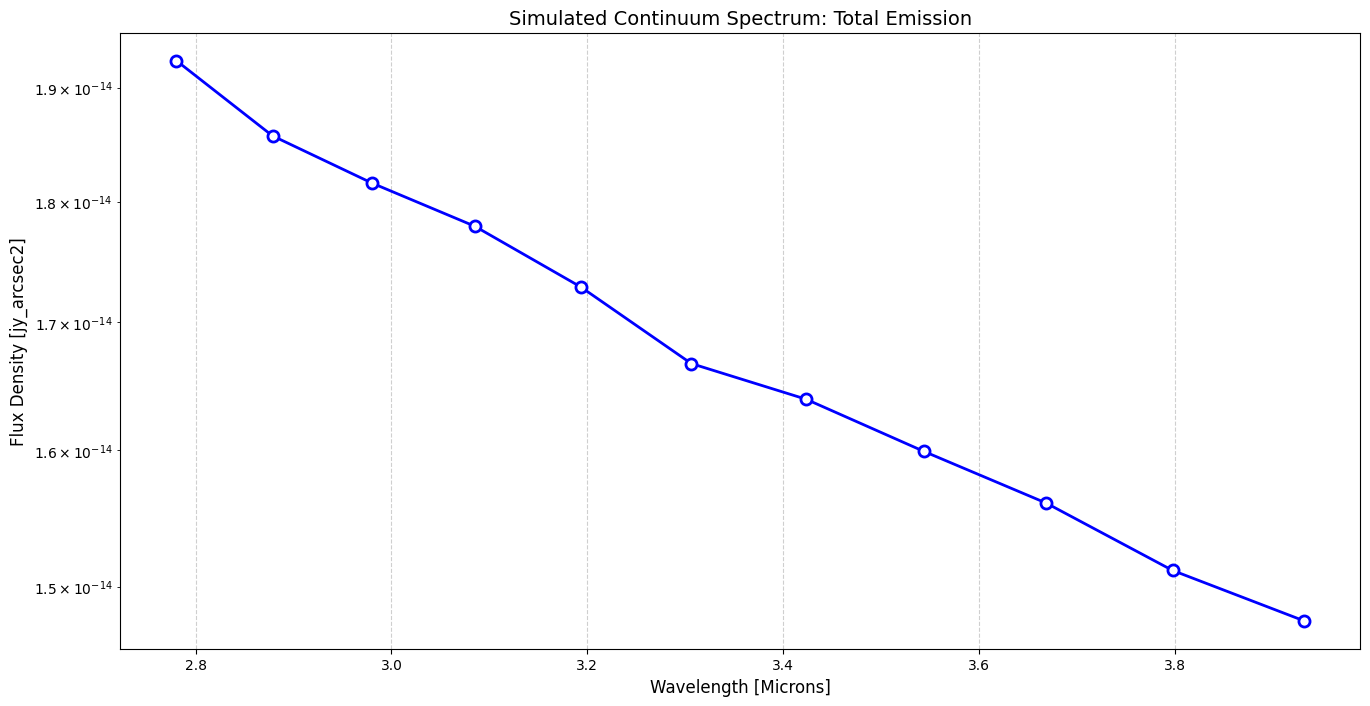

In [13]:
# visualize spectra plot
all_centers, all_y_vals, all_units = create_spectrum_plot(
    ds = all_ds, 
    filter_list = all_filter_list,
    z = z, 
    filter_dir = "filter_bins", 
    flux_type = "total",           # options: "total", "contH", "cont2p", "contff"
    plot_units = "jy_arcsec2"      # options: None, "mag_arcsec2", "jy_arcsec2"
)

plt.figure(figsize = (16, 8))
plt.plot(all_centers, all_y_vals, marker = 'o', linestyle = '-', linewidth = 2, markersize = 8, color = 'blue', markerfacecolor = 'white', markeredgewidth = 2)

# unit formatting for the label
y_label = f"Flux Density [{all_units}]" if all_units != "magnitude_arcsec2" else "Magnitude arcsec$^{-2}$"

plt.xlabel('Wavelength [Microns]', fontsize = 12)
plt.ylabel(y_label, fontsize = 12)
plt.title('Simulated Continuum Spectrum: Total Emission', fontsize = 14)

# log scale is recommended for all units except magnitude_arcsec2 to see faint features
if all_units != "magnitude_arcsec2":
    plt.yscale('log')

plt.grid(True, linestyle = '--', alpha = 0.6)
plt.show()